In [1]:
HOST = '37.139.42.145'
DBNAME = 'game-analytics'
USER = 'analytics'
PASSWORD = 'BRtTaqYiJyr29WXN'
from sqlalchemy import create_engine
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}/{DBNAME}')
import pandas as pd
group_schema='data_viz_1068'


    Задание 1. Постройте rolling retention первых 24 часов жизни игроков в разрезах: органика/неорганика, ios/android, и определите какой из субрегионов наиболее интересен для каждой когорты:
- CIS: РФ, Украина, Белоруссия и т.д. (СНГ)
- Europe: ЕС + Великобритания + Восточная Европа
- North America: США, Канада


In [2]:
#1 задание, rolling ret 24 часа
ret=pd.read_sql(f'''
with data as
     
     (SELECT  event_time, user_id, platform, 
        min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install,
        case WHEN country in ('RU', 'AZ', 'AM', 'BY','KZ', 'KG','MD', 'TJ', 'UZ', 'UA', 'TM') then 'CIS'
             WHEN country in ('DE','BE','IT','LU','NL','FR','DK','IE',
                       'GR','ES','PT','AT','FI','SE','HU','CY','LV','LT','PL','SK','SI','CZ','EE','BG','RO','HR','UK') then 'EU'
             WHEN country in ('CA', 'US') then 'NA'
             else 'Other' end as region,
        user_type,event_name
        
        FROM data_viz_1068.project_dataset
        WHERE user_id in
                (SELECT user_id
                FROM data_viz_1068.project_dataset
                WHERE event_name='FirstLaunchApp')
                and event_name in ('FirstLaunchApp','LaunchApp'))
     
    SELECT max(extract(hour from date_trunc('hours',event_time-date_install))) as lifetime,
    user_id, platform, region,user_type
    FROM data
    WHERE event_time <=(date_install+INTERVAL '1' DAY)
    GROUP BY 2,3,4,5
''', con=engine)
temp_df = pd.DataFrame({'lifehour_rolling':range(0,24)})
temp_df['merge'] = 1
ret['merge'] = 1
rolling_df = pd.merge(temp_df, ret, on = 'merge')
rolling_df = rolling_df[rolling_df['lifetime'] >= rolling_df['lifehour_rolling']]
rolling_df = rolling_df.groupby(['lifehour_rolling', 'region', 'platform', 'user_type'], as_index=0).agg({'user_id':'nunique'})
#rolling_df.to_csv('./downloads/rol24hret.csv', index=False)

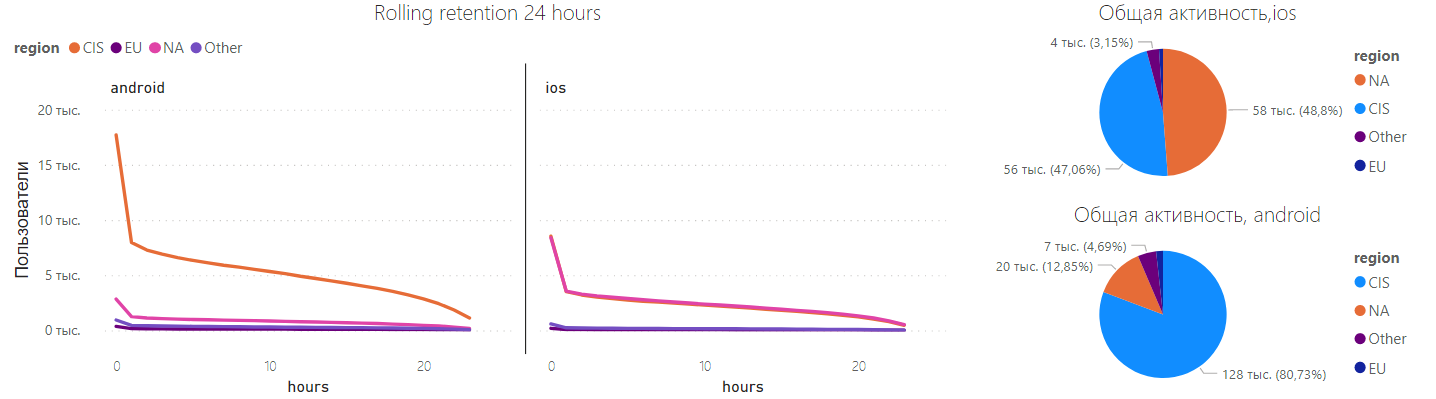

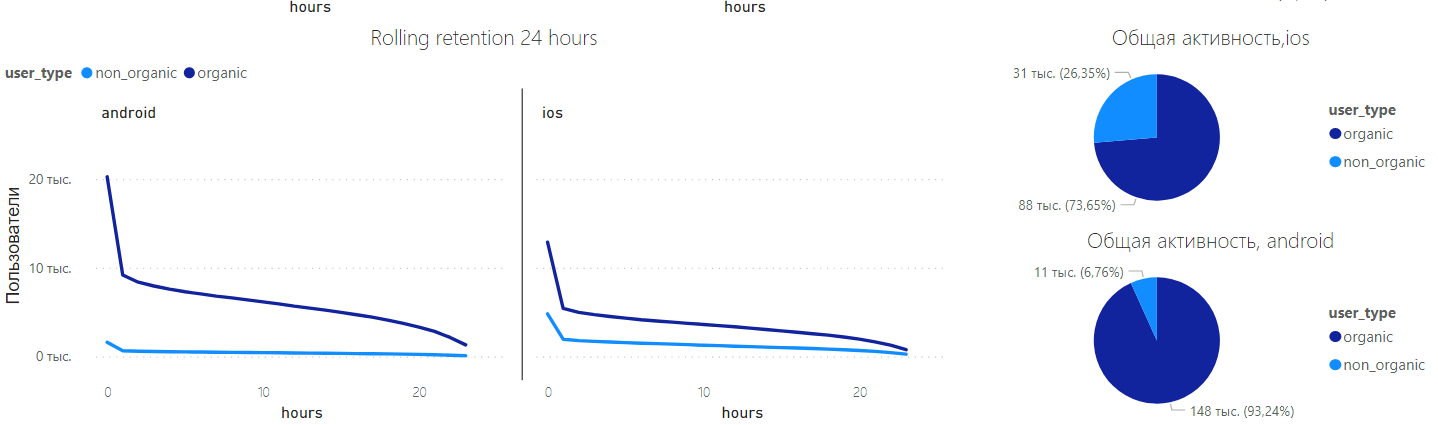

Вывод: Наиболее высокий процент возврата игроков в течение первых 24-х часов относится к органическим пользователям anroid из стран СНГ ('RU', 'AZ', 'AM', 'BY','KZ', 'KG','MD', 'TJ', 'UZ', 'UA', 'TM'). Около 2 тысяч из 18 запускают игру повторно даже под конец первых суток после установки (10%). В IOS же преобладает в этом плане Северная Америка, процент retention на 24 часе примерно в таком же процентов соотношении к числу установок. Остальные когорты имеют более пологие графики и не выделяются возвратом пользователей, графики общей активности подтверждают это.

    Задание 2. Постройте retention rate первых 30 дней жизни игроков в разрезах: органика/неорганика, ios/android, и определите какой из субрегионов (CIS, Europe, North America) наиболее интересен для каждой когорты. Сравните выводы, полученные в п.1-2.


In [3]:
ret=pd.read_sql(f'''
with data as
     (SELECT  event_time, user_id, platform, 
        min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install,
        case WHEN country in ('RU', 'AZ', 'AM', 'BY','KZ', 'KG','MD', 'TJ', 'UZ', 'UA', 'TM') then 'CIS'
             WHEN country in ('DE','BE','IT','LU','NL','FR','DK','IE',
                       'GR','ES','PT','AT','FI','SE','HU','CY','LV','LT','PL','SK','SI','CZ','EE','BG','RO','HR','UK') then 'EU'
             WHEN country in ('CA', 'US') then 'NA'
             else 'Other' end as region,
        user_type,event_name
        
        FROM data_viz_1068.project_dataset
        WHERE user_id in
                (SELECT user_id
                FROM data_viz_1068.project_dataset
                WHERE event_name='FirstLaunchApp')
                and event_name in ('FirstLaunchApp','LaunchApp'))
     
    SELECT lifetime,platform, region,user_type, cast(users as float)/cast(installs as float)*100 as ret
    FROM
        (SELECT lifetime, count(distinct user_id) as users, platform, region,user_type,
        max(count(distinct user_id)) OVER (PARTITION BY platform, region,user_type) as installs
        FROM
            (SELECT max(extract(day from date_trunc('days',event_time-date_install))) as lifetime,
            user_id, platform, region,user_type
            FROM data
            WHERE event_time <=(date_install+INTERVAL '1' MONTH)
            GROUP BY 2,3,4,5) as l
        WHERE lifetime between '0' and '30'
        GROUP BY 1,3,4,5) as q
    ORDER BY 1,2,3,4
    

''', con=engine)


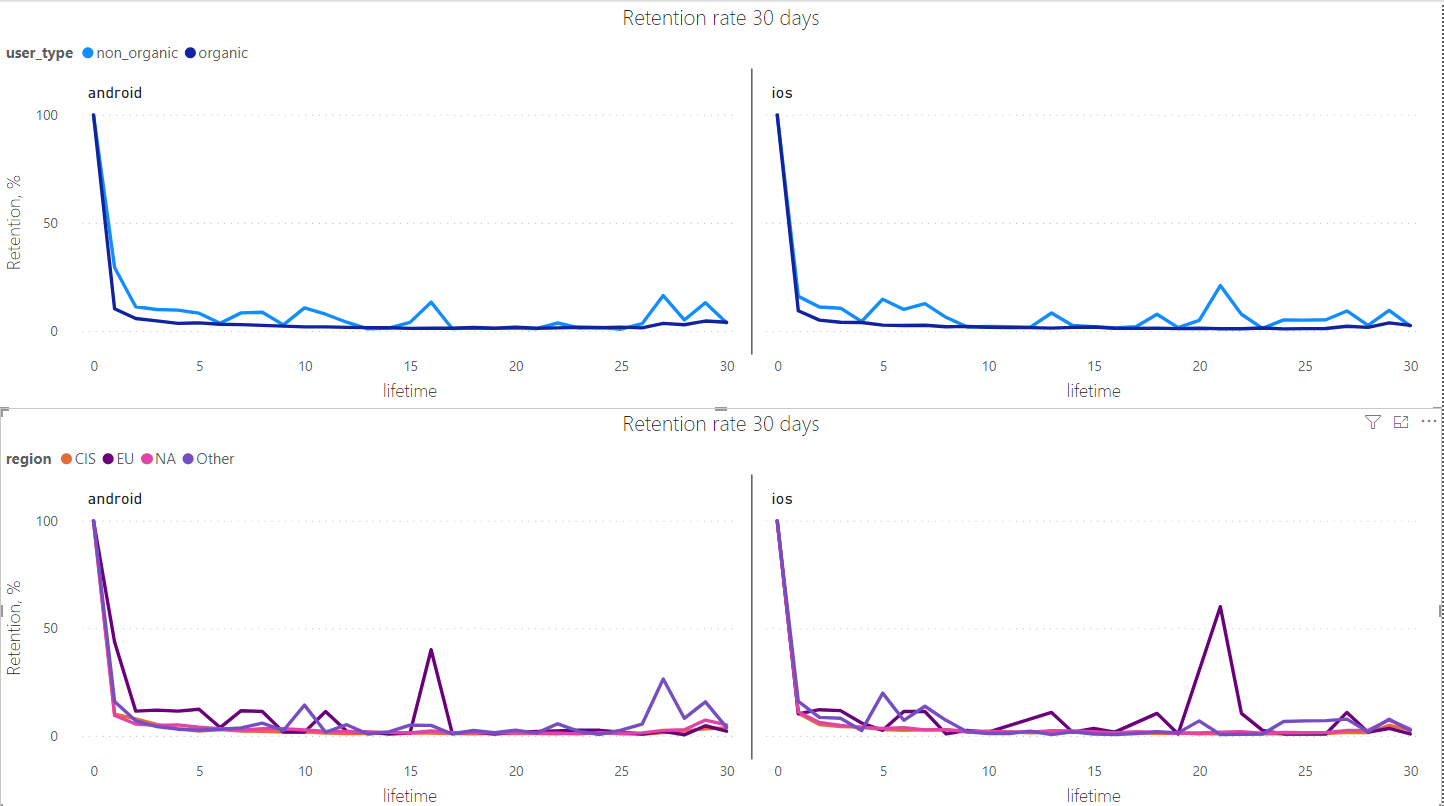

Вывод: В первом задании был сделан вывод, что наилучший возврат принадлежит органическим android пользователям из СНГ. Однако их возврат в течение месяца ничем не примечательнее остальных когорт. Среди данных графиков можно выделить retention  у неорганических пользователей из Европы на обеих платформах. Хоть число установок (из 1 дз) не такое больше у неорганического трафика - retention выше остальных. Скачки в графике скорее всего вызваны тем, что установок не так много, поэтому они более остро выражены. Также, на графике выделяются другие регионы, но стран в них входит куда больше, чем в рассматриваемые 3, поэтому лучше не сравнить с отобранными когортами.

    Задание 3. Постройте retention rate первых 30 дней жизни игроков для помесячных когорт по дате установки только для неорганики. Сравните полученные значения R30 для различных когорт, сделайте выводы

In [4]:
ret_non_organic=pd.read_sql(f'''
with data as
     (SELECT  event_time, user_id,
        min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install,
        event_name
        FROM data_viz_1068.project_dataset
        WHERE user_id in
                (SELECT user_id
                FROM data_viz_1068.project_dataset
                WHERE event_name='FirstLaunchApp') and user_type ='non_organic'
                and event_name in ('FirstLaunchApp','LaunchApp'))
     
    SELECT lifetime,
        month,
        cast(users as float)/cast(installs as float)*100 as ret
    FROM
        (SELECT lifetime, count(distinct user_id) as users, month,
        max(count(distinct user_id)) OVER (PARTITION BY month) as installs
        FROM
            (SELECT max(extract(day from date_trunc('days',event_time-date_install))) as lifetime,
            to_char(date_trunc('month',(min(event_time) filter (where event_name='FirstLaunchApp'))),'YYYY-MM') as month,
            user_id
            FROM data
            GROUP BY 3) as l
        WHERE lifetime between '0' and '30'
        GROUP BY 1,3) as q
    ORDER BY 1,2
    

''', con=engine)
ret_non_organic=ret_non_organic.pivot_table(index = ['month'], columns = 'lifetime', values = 'ret').fillna(0).reset_index()
#ret_non_organic.to_csv('./downloads/ret_non_organic.csv', index=False)

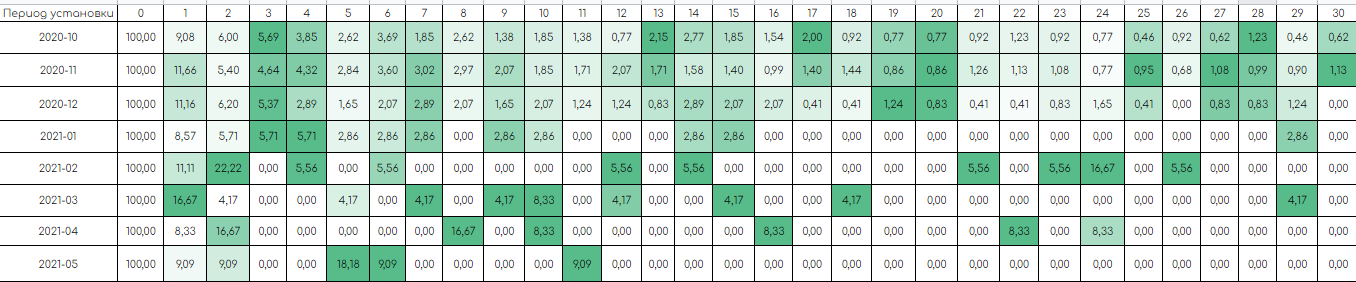
https://docs.google.com/spreadsheets/d/1xNKleL0fT3UD0_sigwwQNfTYIv3uz1TH7ZcWHOywOO0/edit?usp=sharing

Вывод: У неорганического трафика все печально, как и количество установок :)
Возможно, учитывая, что закупа трафика (наверно в этом причина) почти не было после ноября-декабря, то рассматриваемая картина кажется не такой уж и плохой. Но это всего лишь предположения, так как данных о закупочных кампаниях нет. 

    Дополнительно выведена информация по органическому трафику, данные не преобразованы,т.к. задание не предусматривалось. Но даже по таким данных уже видно, что у органическому трафика возврат в разы лучше. 

In [5]:
ret_organic=pd.read_sql(f'''
with data as
     (SELECT  event_time, user_id,
        min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install,
        event_name
        FROM data_viz_1068.project_dataset
        WHERE user_id in
                (SELECT user_id
                FROM data_viz_1068.project_dataset
                WHERE event_name='FirstLaunchApp') and user_type ='organic'
                and event_name in ('FirstLaunchApp','LaunchApp'))
     
    SELECT lifetime,
        month,
        cast(users as float)/cast(installs as float)*100 as ret
    FROM
        (SELECT lifetime, count(distinct user_id) as users, month,
        max(count(distinct user_id)) OVER (PARTITION BY month) as installs
        FROM
            (SELECT max(extract(day from date_trunc('days',event_time-date_install))) as lifetime,
            to_char(date_trunc('month',(min(event_time) filter (where event_name='FirstLaunchApp'))),'YYYY-MM') as month,
            user_id
            FROM data
            GROUP BY 3) as l
        WHERE lifetime between '0' and '30'
        GROUP BY 1,3) as q
    ORDER BY 1,2
    

''', con=engine)
ret_organic.pivot_table(index = ['month'], columns = 'lifetime', values = 'ret').fillna(0).reset_index()

lifetime,month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
0,2020-10,100.0,10.324484,5.899705,7.669617,2.654867,2.064897,1.769912,2.359882,2.654867,...,1.179941,0.884956,1.769912,0.294985,0.000000,0.884956,0.294985,0.294985,0.884956,0.884956
1,2020-11,100.0,8.681233,5.696449,4.213812,3.667577,2.965275,2.692158,2.458057,2.028872,...,0.760827,0.838861,0.682794,0.702302,0.546235,0.526726,0.643777,0.507218,0.312134,0.526726
2,2020-12,100.0,9.752066,5.714286,4.911452,2.739079,2.668241,2.266824,2.172373,1.794569,...,0.779221,0.448642,0.401417,0.543093,0.472255,0.283353,0.495868,0.590319,0.306966,0.401417
3,2021-01,100.0,9.517045,5.160985,4.119318,3.267045,2.509470,1.799242,2.178030,2.320076,...,0.520833,0.473485,0.662879,0.710227,0.473485,0.331439,0.473485,0.757576,0.142045,0.473485
4,2021-02,100.0,8.670520,5.138086,4.431599,3.082852,3.018626,1.991008,1.926782,2.183687,...,0.642261,0.578035,0.449583,0.385356,0.578035,0.706487,0.706487,0.706487,0.449583,0.449583
5,2021-03,100.0,11.190053,6.465364,5.079929,3.303730,2.522202,2.593250,1.989343,2.451155,...,0.746004,0.959147,0.639432,0.674956,0.461812,0.461812,0.426288,0.461812,0.213144,0.284192
6,2021-04,100.0,9.262341,5.546312,3.549639,3.105935,2.773156,2.551303,2.384914,2.273988,...,0.721021,0.665557,0.665557,0.610094,0.499168,0.499168,0.443705,0.721021,0.499168,0.942873
7,2021-05,100.0,10.880000,6.560000,4.800000,4.160000,3.200000,3.520000,3.120000,1.280000,...,0.240000,0.080000,0.240000,0.320000,0.480000,0.320000,0.400000,0.240000,0.240000,0.000000
